In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat
from os.path import basename, exists
from pickle import load, dump

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_wavelength_at_max(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for tag, y in zip(f['/bunches'], arr):
                yield {"tag": tag, "atmax": x[np.argmax(y)]}
        except KeyError:
            return


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            return

In [3]:
runs = [212]
globbed = chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed))
bg_period, bg_mod = 3, 0  # /Background_Period

In [9]:
integ = (
    from_sequence(filenames)
#     .topk(20)  # limit the number of files to be read
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed |  5min 26.5s


,count,summed
is_bg,,
True,54764,"[24209131.0, 24209038.0, 24208958.0, 24209000...."
False,109524,"[48417233.0, 48417280.0, 48417191.0, 48417241...."


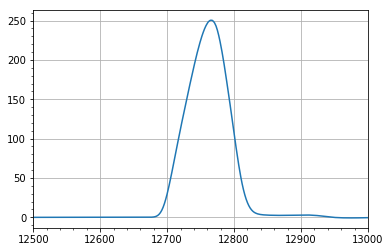

In [12]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(12500, 13000)
# plt.ylim(0, 1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [13]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            _, n = f["/photon_diagnostics/Spectrometer/hor_spectrum"].shape
            x = a * (np.arange(n) - x0) + x1

            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[12600:12900].sum(),
                         'delay_float': dt,
                         'atmax': x[np.argmax(hor)]}
                        for tag, iom, tof, dt, hor
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position'],
                               f["/photon_diagnostics/Spectrometer/hor_spectrum"]))
        except KeyError:
            return


def read_from_cache(filename, rewrite=False):
    cache = f"../cache/{basename(filename)}.pickle"
    if exists(cache) and not rewrite:
        with open(cache, "br") as f:
            loaded = load(f)
    else:
        loaded = [v for v in read_scala(filename)]
        with open(cache, "bw") as f:
            dump(loaded, f)
    yield from loaded


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_from_cache)
        .flatten()
        .to_dataframe()
        .compute()
    )
df = df.set_index("tag").sort_index()
df

[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed | 15min 14.4s


,atmax,delay_float,iom_intensity_pc,tof_intensity,is_bg,phi_float,delay
tag,,,,,,,
486595947,80.658835,-7.000878,11.453247,132550,True,2.377652,-7.000
486595948,80.701818,-7.000878,13.892555,127851,False,0.760040,-7.000
486595949,80.646555,-7.000878,11.913300,113839,False,2.840143,-7.000
486595950,80.661905,-7.000878,12.479782,132546,True,2.262051,-7.000
486595951,80.634274,-7.000878,11.470413,106582,False,3.302775,-7.000
486595952,80.655765,-7.000878,11.652374,118341,False,2.493261,-7.000
486595953,80.643484,-7.000878,11.942482,132503,True,2.955788,-7.000
486595954,80.661905,-7.000878,12.490082,113055,False,2.262051,-7.000
486595955,80.646555,-7.000878,11.920166,115486,False,2.840143,-7.000


In [15]:
def binit(d):
    centers = np.arange(-10, 0, 0.03)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


df["delay"] = df["delay_float"].apply(binit)
df["delay"].unique()

array([-7.  , -6.97, -6.94, -6.91, -6.88, -6.85, -6.82, -6.79, -6.76,
       -0.01, -6.73, -6.7 , -6.67, -6.64, -6.61, -6.58, -6.55, -6.52,
       -6.49, -6.46, -6.43, -6.4 , -6.37, -6.34, -6.31, -6.28, -6.25,
       -6.22, -6.19, -6.16])

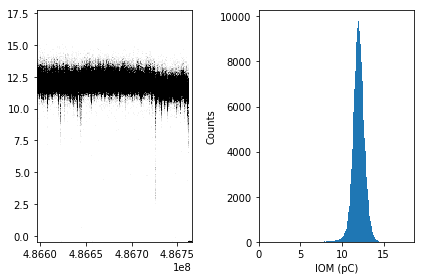

In [19]:
plt.figure()
plt.subplot(121)
plt.hist2d(df.index, df["iom_intensity_pc"], bins=[200, 200], cmap="Greys")
plt.clim(0, 1e1)
plt.subplot(122)
plt.hist(df["iom_intensity_pc"], bins=200)
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.xlim(0, None)
plt.tight_layout()
plt.show()

In [31]:
groupped

count        sum
delay is_bg                  
-7.00 False   3343  377366019
      True    1673  221735322
-6.97 False   3305  375962058
      True    1651  218820576
-6.94 False   3316  375617722
      True    1657  219619218
-6.91 False   6666  750064359
      True    3334  441855490
-6.88 False   3332  369857265
      True    1667  220915524
-6.85 False   3333  371885448
      True    1667  220930914
-6.82 False   3344  368928450
      True    1672  221624731
-6.79 False   3322  364774527
      True    1662  220288211
-6.76 False   6666  725846501
      True    3333  441760372
-6.73 False   3330  359916670
      True    1665  220706123
-6.70 False   3333  355259327
      True    1667  220687919
-6.67 False   3334  354373327
      True    1666  220814577
-6.64 False   3332  351565576
      True    1667  220937065
-6.61 False   6667  700054043
      True    3333  441732674
-6.58 False   3333  347090979
      True    1667  220927546
-6.55 False   3334  350810230
      True    1666  220800385
-6.52 False   3333  354640119
      True    1667  220941283
-6.49 False   3334  361953321
      True    1668  221085022
-6.46 False   6469  727911569
      True    3235  428830745
-6.43 False   3331  388336844
      True    1667  220991723
-6.40 False   3315  395567650
      True    1657  219687230
-6.37 False   3320  404593003
      True    1656  219538055
-6.34 False   3317  409523841
      True    1658  219797558
-6.31 False   6665  831345676
      True    3334  442044562
-6.28 False   3332  421308212
      True    1666  220887025
-6.25 False   3314  425171697
      True    1657  219681120
-6.22 False   3334  432127169
      True    1666  220909556
-6.19 False   1417  185133415
      True     708   93870020

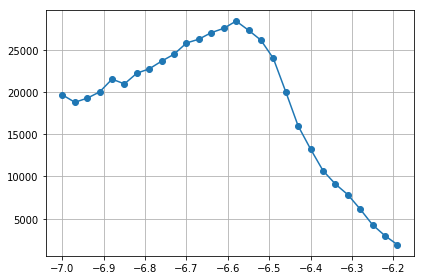

In [32]:
plt.figure()
where = (
    (5 < df["iom_intensity_pc"])
    & (df["delay"] < -1)
)
groupped = df[where].groupby(['delay', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
diff = -(
    (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count'])
        .reset_index(level=[1], drop=True)
    - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count'])
        .reset_index(level=[1], drop=True)
)
plt.plot(diff, 'o-')
plt.grid(True)
plt.tight_layout()
plt.show()